# 2025-10-22 Regression

* Bias-variance tradeoff

* Linear models

* Loss functions and partial derivatives

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# With Chebyshev polynomials
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

# And our "bad" function
runge(x) = 1 / (1 + 10*x^2)

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# And a helper for looking at conditioning
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

## Bias-variance tradeoff

The expected error in our approximation $\hat{f} \left( x \right)$ of noisy data $y = f \left( x \right) + \epsilon$ (with $\epsilon \approx \mathcal{N} \left( 0, \sigma \right)$) can be decomposed as

$$ E \left[ \left( \hat{f} \left( x \right) - y \right)^2 \right] = \sigma^2 + \left( \underbrace{ E \left[ \hat{f} \left( x \right) \right] - f \left( x \right)}_{\text{Bias}} \right)^2 + \underbrace{E \left[ \hat{f} \left( x \right)^2 \right] - E \left[ \hat{f} \left( x \right) \right]^2}_{\text{Variance}} $$

The $\sigma^2$ term in irreducible error (purely due to observation noise), but bias and variance can be controlled by model selection.
More complex models are more capable of expressing the underlying function $f \left( x \right)$, and thus are more capable of reducing bias.
However, they are also more affected by noise, thereby increasing variance.

## Regression using polynomials

What happens as we change the order of our Chebyshev polynomial fit?

(size(ytrain), size(yfit)) = ((500,), (500,))


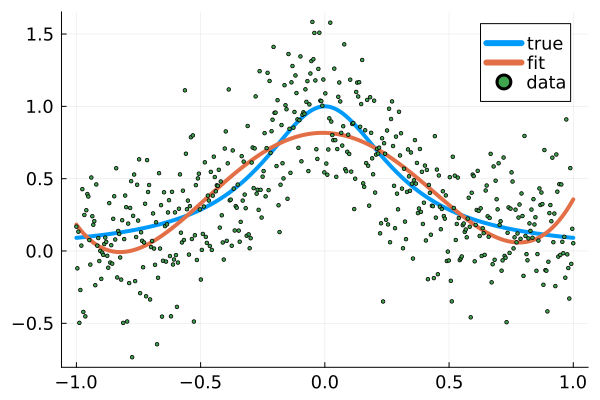

In [2]:
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

# First let's make some noisy data
runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

# And fit our model
x = LinRange(-1, 1, 500)
ytrain = runge_noisy(x, 0.3)
yfit = chebyshev_regress_eval(x, x, 5) * ytrain
@show size(ytrain), size(yfit)

# And plot
plot(x, runge.(x), label="true")
plot!(x, yfit, label="fit")
scatter!(x, ytrain, markersize=2, label="data")

What would be a 'good' fit here in the presence of noise?

In [3]:
ytest = runge_noisy(x, 0.3)
@show norm(yfit - ytrain)
@show norm(yfit - ytest);

norm(yfit - ytrain) = 6.867102943814644
norm(yfit - ytest) = 6.663493966695996


Which order seems to best capture the underlying true data without the noise?

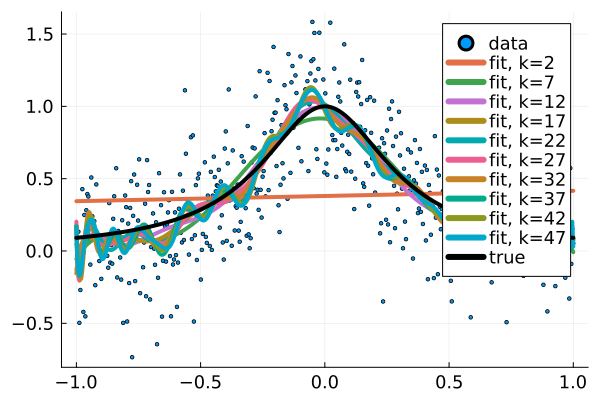

In [4]:
ks = 2:5:50
p = scatter(x, ytrain, markersize=2, label="data")

function residuals(k)
    # Fit polynomial of degree k to ytrain.
    yfit = chebyshev_regress_eval(x, x, k) * ytrain
    plot!(x, yfit, label="fit, k=$k")
    [norm(yfit - ytrain) norm(yfit - ytest)]
end

res = vcat([residuals(k) for k in ks]...)
plot!(x, runge.(x), color=:black, label="true")

What about from this plot?
Which degree seems to be the best at matching the underlying data without overfitting to the noise?

size(res) = (10, 2)


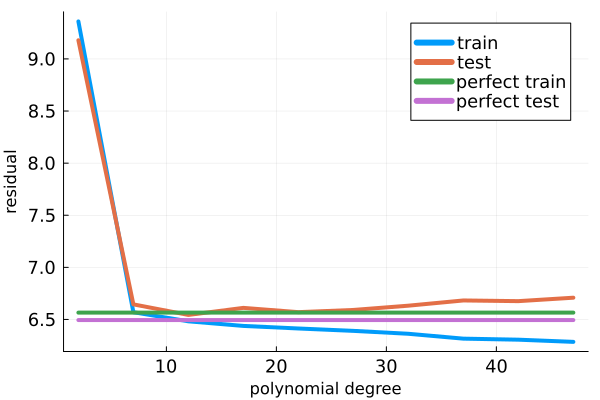

In [5]:
@show size(res)

plot(ks, res[:,1], label="train", xlabel="polynomial degree", ylabel="residual")
plot!(ks, res[:,2], label="test")
plot!(ks, _ -> norm(runge.(x)-ytrain), label="perfect train")
plot!(ks, _ -> norm(runge.(x)-ytest), label="perfect test")

## Exploration

What have we just done?

We took one noisy sample of a function.
We fit polynomials of increasing degree to it.
We then computed the residual of that fit on the training data and an independent "test" sample.

Think about these questions, re-run the notebook, and try to formulate an answer.
Please discuss online (Zulip or with a friend).

* Is "perfect train" (residual for the noisy sample of the zero-noise function) always greater than (or less than) "perfect test"?

* Can you identify when we begin "overfitting" by comparing "train" with "perfect train"?
Does it happen at about the same degree each time?

* In the real world, we don't have access to the zero-noise function, and thus can't mark "perfect train".
By looking at just "train" and "test", can you identify (roughly) when we begin overfitting?

## Bias and variance over multiple training sets

What have we just done?

* We took one noisy sample of a function

* Fit polynomials of increasing degree to it

* Computed the residual of the fit on both the training data and and independent 'test' sample

What happens if we repeat the process?
Try it!

## Stacking many realizations

If each fit will be a bit wrong, let's see if we can identify some underlying tendencies.

Run this cell below for different values of `degree` (set it back to `7` when you're done).

Note that:

* Low-degree polynomials are not rich enough to capture the peak of the function.

* As we increase degree, we are able to resolve the peak better, but see more erratic behavior near the ends of the interval.
This erratic behavior is **overfitting**, which we'll quantify as **variance**.

* This tradeoff is fundamental: richer function spaces are more capable of approximating the functions we want, but they are more easily distracted by noise.

size(Y) = (500, 50)


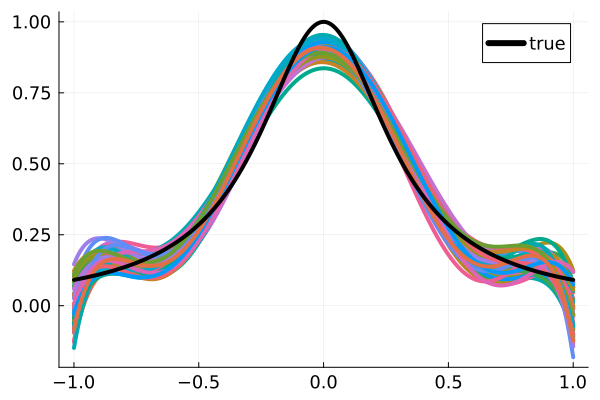

In [6]:
degree = 7
Y = []
for i in 1:50
    yi = runge_noisy(x, 0.25)
    push!(Y, chebyshev_regress_eval(x, x, degree) * yi)
end

Y = hcat(Y...)
@show size(Y) # (number of points in each fit, number of fits)
plot(x, Y, label=nothing);
plot!(x, runge.(x), color=:black, label="true")

## Mean over all realizations

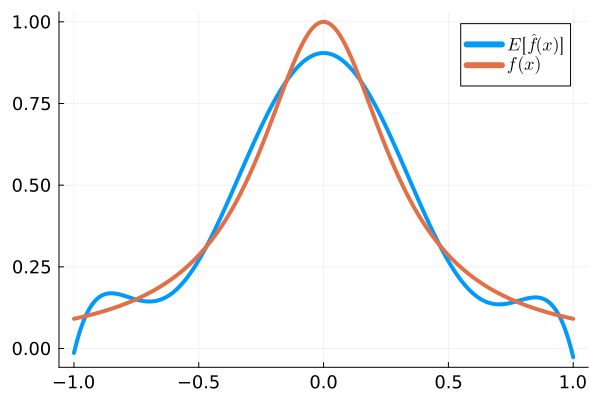

In [7]:
Ymean = sum(Y, dims=2) / size(Y, 2)
plot(x, Ymean, label="\$ E[\\hat{f}(x)] \$")
plot!(x, runge.(x), label="\$ f(x) \$")

## Variance over all realization

size(Yvar) = (500, 1)


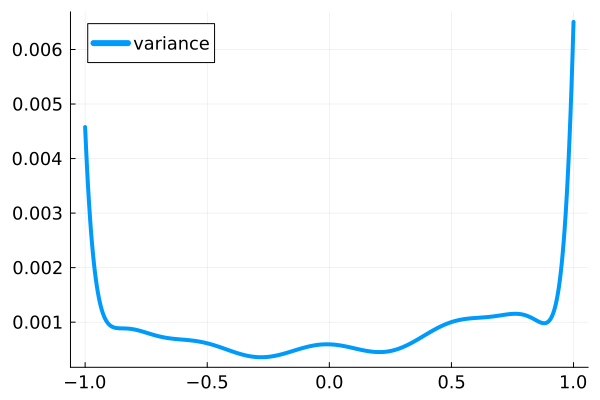

In [8]:
function variance(Y)
    """Compute the Variance as defined at the top of this activity"""
    (sum(Y.^2, dims=2) / size(Y, 2)) - (sum(Y, dims=2) / size(Y, 2)).^2
end

Yvar = variance(Y)
@show size(Yvar)
plot(x, Yvar, label="variance")

## Runge phenomenon - another take

The fact that variance blows up toward the end of our interval is a property of the approximation space (polynomials).
Recall that it doesn't depend on the basis used for fitting (Chebyshev in this case); that choice only relates to stability.
If we could choose an approximation space such that variance was flat across the interval $\left[ -1, 1 \right]$, we would be able to solve interpolation problems on equally spaced grids without numerical artifacts like the Runge phenomenon.
Finding spaces of functions have flat variance and are rich enough to approximate interesting functions is "hard" (e.g. has no general solution).
It is possible in special circumstances, such as for periodic functions, in which the Fourier basis (sine and cosine functions) can be used.

In practice, we often use **regularization** to modify the least squares objective such that we can reduce variance while using function spaces rich enough to keep bias low.